# Imports

In [138]:
try:
  import iminuit
  from iminuit import Minuit
  from iminuit.cost import LeastSquares
except:
  print('Error Initialising Iminuit')

In [139]:
from IPython.display import Latex
import sympy as sp
import scipy as sc
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

/tmp/ipykernel_158274/291558038.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


# Funzioni

In [140]:
def sturges(data):
  return int(1 + np.log2(len(data)))

In [186]:
def grafico(x,y,xerr,yerr, title, xlabel='x', ylabel='y', save=False):

  fig,ax = plt.subplots(1,1)

  ax.scatter(x,y, c='k')
  ax.errorbar(x,y,xerr=xerr,yerr=yerr,linestyle='None', color='k', markersize=8, capsize=5, alpha=0.5)
  # ax.set_title(title)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  if save:  plt.savefig(title+'.pdf')
  return ax

In [141]:
#function for removing Nan values from a numpy array
def rNan(arr): return arr[~np.isnan(arr)]

In [142]:
#@title Test ipotesi
def chi_test(fval, ndof, x_limit = 40):
  '''This funciton visualizes the chi2 test for a given chi2 value and degrees of freedom
  Values
  -------

    `fval` : chi2 value

    `ndof` : degrees of freedom
    `x_limit` : chi2 value limit for integral (don't change)
  '''

  x = np.linspace(0,x_limit, 1000)
  y = [sc.stats.chi2.pdf(i,df=ndof) for i in x]

  section = np.arange(fval, x_limit)
  plt.fill_between(section,sc.stats.chi2.pdf(section,df=ndof), alpha=.4)
  plt.title('Test $\chi^2$')
  plt.xlabel(r'$\chi^2$')
  plt.ylabel('$pdf(\chi^2)$')
  plt.legend([r'$\tilde\chi^2$ '+f'= {round(fval/ndof,2)} \n p-value = {round(1 - sc.stats.chi2.cdf(fval,ndof),3)*100}%'])
  plt.plot(x,y)

def t_test(tvalue, df,xlim = 7, alpha = 0.05 ):
  '''This function visualizes the t Student test for a given t value and degrees of freedom
    Values:
    -------

    `tvalue` : t Student test Value
    `df` : dergrees of freedom
    `xlim` : limit for integration (don't change)
  '''

  x = np.linspace(-xlim,xlim,2000)
  y = [ sc.stats.t.pdf(i,df) for i in x]

  section1 = np.linspace(-xlim,-tvalue)
  plt.fill_between(section1,sc.stats.t.pdf(section1,df=df), alpha=.4, color='b')

  section2 = np.linspace(tvalue, xlim)
  plt.fill_between(section2,sc.stats.t.pdf(section2,df=df), alpha=.4, color='b')

  # plt.title('t Test')
  plt.xlabel(r't')
  plt.ylabel('pdf(t)')
  plt.legend([r'$\alpha$'+f' = {round((1-sc.stats.t.cdf(tvalue,df=df))*2, 4)}'])
  plt.plot(x,y)
  return (1-sc.stats.t.cdf(tvalue,df=df))*2

In [143]:
#@title Error Propagation no Covariance

def formula_errori(parametri:str, formula:str, latex_ = False):

    #convert from str to sympy
    parametri = sp.sympify(parametri)
    formula = sp.simplify(formula)
    sigmas = sp.symbols([f'sigma_{var}' for var in parametri])
    i,exp = 0,0

    for val in parametri:

        #squared partial derivatives and sigmas
        exp += sp.diff(formula,val)**2 * sigmas[i]**2
        i+=1

    exp = sp.sqrt(exp)

    if latex_: return '$'+sp.latex(exp)+'$'

    return (exp)

def valuta_errori(formula_errori:str, values:dict, errors:dict, x:dict=None):

  #convert minuit values method to dict
  params = values.keys()

  #sustitute numerical values
  expr = formula_errori.subs(values)

  for val in errors:

    #substitute numerical for sigmas
    expr = expr.subs(f'sigma_{val}', errors[val])

  if x != None: expr = expr.subs(x)

  return expr

In [144]:
# @title media pesata
def media_pesata(x,err) -> tuple['media','sigma']:

  x_ = np.array(x)
  err_ = np.array(err)

  if x_.shape != err_.shape:
    raise Exception('Size mismatch, control arrays!')
    return

  s1,s2 = 0,0
  for i,j in zip(x_,err_):

    s1 += i/j**2
    s2 += 1/j**2

  media = s1/s2
  sigma = np.sqrt(float(1/s2))

  return media,sigma

# Dati

In [145]:
data = 'https://docs.google.com/spreadsheets/d/11Db4q9pAoPY3wLuFJ6OIKQspeL21LUiSDEYFjaHlQyw/'
df = pd.read_excel(data+'export?format=xlsx',sheet_name=None)
print(df.keys())

dict_keys(['Rv', 'Ra', 'Ra2 ', 'Ohm', 'Serie', 'Parallelo', 'Partitore', 'Diodo', 'D2'])


In [146]:
def R_parall(R1,R2):
  return (R1*R2)/(R1+R2)

# Rv

In [147]:
RV_dati = df['Rv']
# print(RV_dati)

In [184]:
def plotter(x,y):
    
    plt.scatter(x,y)
    plt.xlabel('tensione [V]')
    plt.ylabel('corrente [ $\mu$A ]')

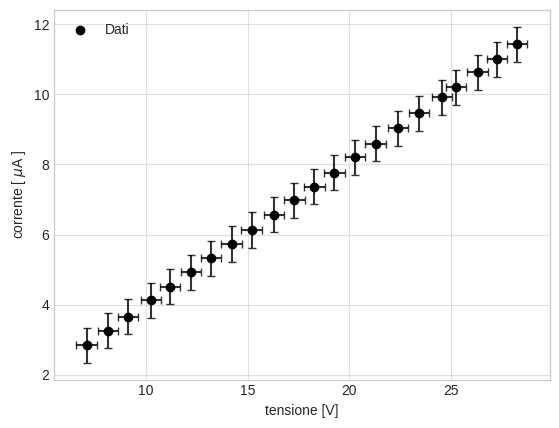

In [209]:
V_rv = RV_dati['V']
I_rv = RV_dati['I [micro A]']

plt.scatter(V_rv,I_rv,color='k')
plt.xlabel('tensione [V]')
plt.ylabel('corrente [ $\mu$A ]')
plt.errorbar(V_rv,I_rv,xerr=0.5,yerr=0.5,linestyle='None', color='k', markersize=8, capsize=3, alpha=.8)
plt.legend(['Dati'])

In [150]:
def ohm_law(V, R):
  return V/R

In [264]:
c = LeastSquares(V_rv, I_rv, 0.02, ohm_law)
m = Minuit(c, R=2)
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 6.957 (χ²/ndof = 0.3)      │              Nfcn = 30               │
│ EDM = 1.03e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ R    │  2.4768   │  0.0014   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────────┐
│   │        R │
├───┼──────────┤
│ R │ 1.92e-06 │
└───┴──────────┘

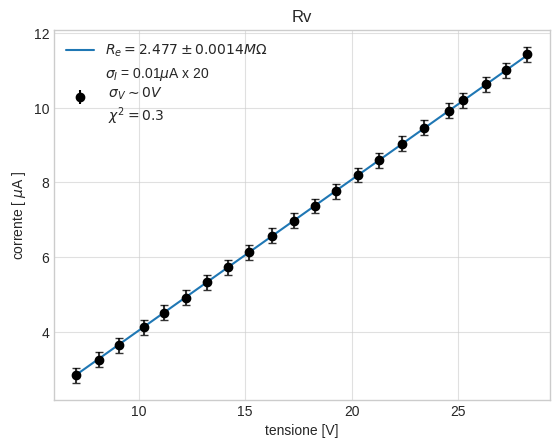

In [265]:
a = m.visualize()
plt.title('Rv')
plt.xlabel('tensione [V]')
plt.ylabel('corrente [ $\mu$A ]')
plt.errorbar(V_rv,I_rv,xerr=0,yerr=0.2,linestyle='None', color='k', markersize=8, capsize=3, alpha=.8)
plt.legend([f'$R_e = {m.values["R"]:.{3}f} \pm {m.errors["R"]:.{4}f} M\Omega$',f'$\sigma_I$ = 0.01$\mu$A x 20 \n $\sigma_V \sim 1 mV$ \n $\chi^2 = {m.fval/m.ndof:.{1}f}$'])
plt.savefig('Rv.pdf',bbox_inches='tight')
plt.show()

In [152]:
R2 = 3.272
Req = m.values['R']

print(R2*Req/(R2-Req))

10.190484353080327


# Ra

In [246]:
RA_dati = df['Ra']
# print(RA_dati)

In [266]:
c = LeastSquares(RA_dati['V'][:8], RA_dati['I [mA]'][:8], 0.0001, ohm_law)
m = Minuit(c, R=1)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.155e+04 (χ²/ndof = 3078.5)│              Nfcn = 47               │
│ EDM = 3.47e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ R    │110.1593e-3│ 0.0014e-3 │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────────┐
│   │        R │
├───┼──────────┤
│ R │ 1.97e-12 │
└───┴──────────┘

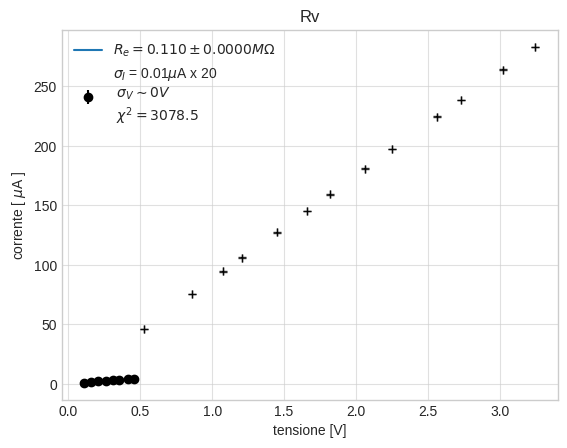

In [269]:
a = m.visualize()
leg = [f'$R_e = {m.values["R"]:.{3}f} \pm {m.errors["R"]:.{4}f} M\Omega$',
       f'$\sigma_I$ = 0.01$\mu$A x 20 \n $\sigma_V \sim 0 V$ \n $\chi^2 = {m.fval/m.ndof:.{1}f}$']
plt.title('Rv')
plt.xlabel('tensione [V]')
plt.ylabel('corrente [ $\mu$A ]')
plt.errorbar(RA_dati['V'],RA_dati['I [mA]'],xerr=0,yerr=0.2,linestyle='None', color='k', markersize=8, capsize=3, alpha=.8)
plt.legend(leg)
plt.savefig('Rv.pdf',bbox_inches='tight')
plt.show()

In [249]:
c = LeastSquares(RA_dati['V'][8:], RA_dati['I [mA]'][8:]*1e-3, 0.001, ohm_law)
m = Minuit(c, R=1)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.022 (χ²/ndof = 0.1)      │              Nfcn = 52               │
│ EDM = 2.03e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ R    │  11.445   │   0.018   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────────┐
│   │        R │
├───┼──────────┤
│ R │ 0.000313 │
└───┴──────────┘

In [250]:
RA = m.values['R']-9.9
print(RA)

1.545063644753517


# Legge Ohm


In [251]:
Ohm = df['Ohm']
print(Ohm.keys())

Index(['Resistenza kΩ', 'Unnamed: 1', 'V 1', 'Ι [μA] 1', 'Unnamed: 4', 'V 2',
       'I [μA] 2', 'Unnamed: 7'],
      dtype='object')


## Configurazione 1

In [252]:
c = LeastSquares(Ohm['V 1'], Ohm['Ι [μA] 1']*1e-6, 1e-8, ohm_law)
m = Minuit(c, R=2)
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 52.67 (χ²/ndof = 2.2)      │              Nfcn = 153              │
│ EDM = 3.23e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ R    │ 147.454e3 │  0.019e3  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────┐
│   │   R │
├───┼─────┤
│ R │ 362 │
└───┴─────┘

0.3395117463920308


0.7441829110423619

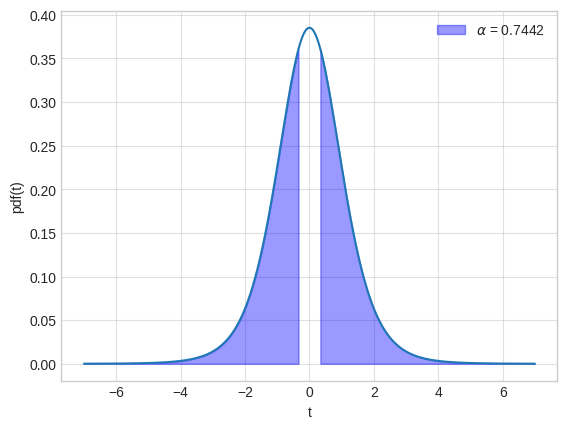

In [253]:
t = abs(m.values['R']-150e3)/np.sqrt((m.errors['R']**2)/7 + (7.5e3)**2)
print(t)
t_test(t, 7)

## Configurazione 2

In [254]:
c = LeastSquares(Ohm['V 2'], Ohm['I [μA] 2']*1e-6, 1e-6, ohm_law)
m = Minuit(c, R=2)
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.002008 (χ²/ndof = 0.0)   │              Nfcn = 150              │
│ EDM = 1.84e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ R    │  149.5e3  │   1.4e3   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────────┐
│   │        R │
├───┼──────────┤
│ R │ 2.06e+06 │
└───┴──────────┘

0.06427711012361824


0.9505466382893668

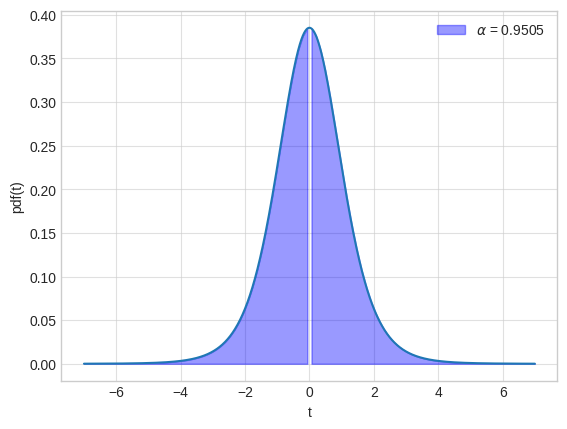

0.06427711012361824


KeyboardInterrupt: 

In [ ]:
t = abs(m.values['R']-150e3)/np.sqrt((m.errors['R']**2)/7 + (7.5e3)**2)
print(t)
t_test(t, 7)

# R Serie

In [ ]:
R_serie = df['Serie']

In [ ]:
c = LeastSquares(R_serie['V'], R_serie['I']*1e-6, 1e-5, ohm_law)
m = Minuit(c, R=2)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.141e-05 (χ²/ndof = 0.0)  │              Nfcn = 146              │
│ EDM = 8.77e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ R    │  0.30e6   │  0.08e6   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────────┐
│   │        R │
├───┼──────────┤
│ R │ 5.97e+09 │
└───┴──────────┘

# R //

In [ ]:
R_par = df['Parallelo']

In [ ]:
c = LeastSquares(R_par['V'], R_par['I']*1e-6, 1e-6, ohm_law)
m = Minuit(c, R=2)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.1325 (χ²/ndof = 0.0)     │              Nfcn = 138              │
│ EDM = 7.99e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ R    │  74.7e3   │   0.5e3   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────────┐
│   │        R │
├───┼──────────┤
│ R │ 2.43e+05 │
└───┴──────────┘

# Diodo 

In [ ]:
Diodo = df['Diodo']
print(Diodo.keys())

Index(['diodo IN4006', 'V 1', 'I [mA] 1', 'Unnamed: 3', 'Unnamed: 4', 'V 2',
       'I [mA] 2'],
      dtype='object')


In [ ]:
V1_diodo = rNan(Diodo['V 1'])
I1_diodo = rNan(Diodo['I [mA] 1'])

V2_diodo = rNan(Diodo['V 2'])
I2_diodo = rNan(Diodo['I [mA] 2'])

In [ ]:
def linear(x,a,c):
    return a*x+c

In [ ]:
diodo_1_rid = [],[]
for i,j in zip(np.array(V1_diodo),np.array(I1_diodo)):
    tmp = np.log(j)
    if np.isnan(tmp):
        continue
    elif tmp == -np.inf:
        continue
    else:
        diodo_1_rid[0].append(i)
        diodo_1_rid[1].append(tmp)


diodo_1_rid = np.array(diodo_1_rid)

/tmp/ipykernel_158274/1633179446.py:3: RuntimeWarning: divide by zero encountered in log
  tmp = np.log(j)


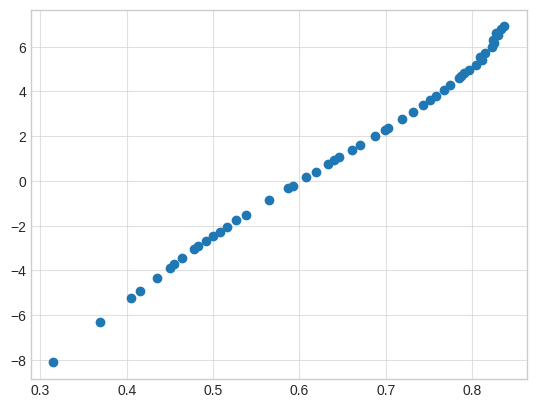

In [ ]:
plt.scatter(diodo_1_rid[0], diodo_1_rid[1])

In [ ]:
v = 0
i = 3
while v < 1:
    c = LeastSquares(diodo_1_rid[0][:i], diodo_1_rid[1][:i], np.log(1.1), linear)
    m = Minuit(c, a=1, c=0)
    m.migrad()
    v = m.fval/m.ndof
    i+=1
print(i)
m.migrad()

18


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 19.74 (χ²/ndof = 1.3)      │              Nfcn = 48               │
│ EDM = 8.87e-19 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   29.0    │    0.4    │            │            │         │         │       │
│ 1 │ c    │  -17.02   │   0.17    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────┐
│   │      a      c │
├───┼───────────────┤
│ a │   0.14 -0.065 │
│ c │ -0.065 0.0308 │
└───┴───────────────┘

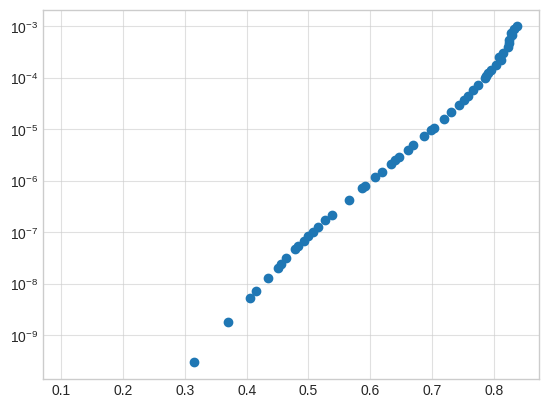

In [ ]:
plt.scatter(Diodo['V 1'], Diodo['I [mA] 1']*1e-6)
plt.yscale('log')

In [ ]:
def shockley(Io, V):
  g = 1e-3
  q = 1.6e19
  k = 1.38e23
  T = 300

  return Io*(np.exp(V*q/(g*k*T))-1)

# Diodo 2


In [ ]:
D2 = df['D2']

In [ ]:
def shockley(V,Io,g=3):
  
  q = 1.602e-19
  k = 1.38e-23
  T = 300

  return Io*(np.exp(V*q/(g*k*T))-1)

In [ ]:
chi = 0
val1,val2 = 0,4
while chi<1:
    
    val2 +=1
    c = LeastSquares(D2['V [mV] 1'][val1:val2], D2['I [mA] 1'][val1:val2], D2['err A'][val1:val2]*1e1, shockley)
    m = Minuit(c, Io=1, g=1)
    m.migrad()
    chi = m.fval/m.ndof
print(val2)
print('Tensione limite: ',D2['V [mV] 1'][val2-1])
m.migrad()


19
Tensione limite:  0.622


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 48.55 (χ²/ndof = 2.9)      │              Nfcn = 303              │
│ EDM = 1.48e-10 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Io   │  21.3e-9  │  1.9e-9   │            │            │         │         │       │
│ 1 │ g    │   1.311   │   0.008   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────┐
│    │             Io              g │
├────┼───────────────────────────────┤
│ Io │       3.49e-18 15.3376698e-12 │
│  g │ 15.3376698e-12       6.74e-05 │
└────┴───────────────────────────────┘

In [ ]:
chi = 0
val1,val2 = 0,4
while chi<20:
    
    val2 +=1
    c = LeastSquares(D2['V [mV] 2'][val1:val2], D2['I [mA] 2'][val1:val2], D2['err A2'][val1:val2]*2e2, shockley)
    m = Minuit(c, Io=1, g=1)
    m.migrad()
    chi = m.fval/m.ndof
    print(chi)
print(val2)
print('Tensione limite: ',D2['V [mV] 1'][val2-1])
m.migrad()


0.0008687615146965419
0.002575710858363568
0.0093734350535706
0.0002844110557574471
0.0002638484069832352
0.04360820604121896
0.10561295454167935
0.1540632457762471
1.0566577557841166
0.9689764598098326
0.9259626367691879
0.8883698532636952
0.9153404427967139
0.8944920787884267
1.226589222027715
1.324499243804348
1.5033698721008715
1.945858858046379
2.2135663782310053
3.254732133697924
3.47003762213723
3.403935158349102
3.3118807196541518
3.613533849149204
3.482323209900585
3.3580351516228966
3.2552846966795426
3.191874525095839
3.094781187357155
3.125721567587697
3.114743541466507
3.1514184873025934
3.1106224957822346
3.1617898300664433
3.204318647704806
4.059465633402763
3.9678871811911645
3.8877802956420453
3.961415427706603
4.849035287896465
10.37199826718901
nan
46
Tensione limite:  1.324


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = nan                        │              Nfcn = 390              │
│ EDM = nan (Goal: 0.0002)         │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Io   │     1     │    nan    │            │            │         │         │       │
│ 1 │ g    │     1     │    nan    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────┐
│    │  Io   g │
├────┼─────────┤
│ Io │ nan nan │
│  g │ nan nan │
└────┴─────────┘

In [ ]:
def linear(x,a,b):
    return a*x+b

In [ ]:
D1_V,D1_I,D1_I_err = [],[],[]

for i,j,k in zip(D2['V [mV] 2'], D2['I [mA] 2'], D2['err A2']):
    tmp = np.log(j)
    if np.isnan(tmp): continue
    else : D1_V.append(i), D1_I.append(tmp), D1_I_err.append(k/j)

D1_V,D1_I,D1_I_err = np.array(D1_V),np.array(D1_I),np.array(D1_I_err)
# print(D1_I)

In [ ]:
c = LeastSquares(D1_V[8:],D1_I[8:],D1_I_err[8:]*1e3, linear)
m = Minuit(c, a=1, b=1)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = nan                        │              Nfcn = 210              │
│ EDM = nan (Goal: 0.0002)         │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │     1     │    nan    │            │            │         │         │       │
│ 1 │ b    │     1     │    nan    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────┐
│   │   a   b │
├───┼─────────┤
│ a │ nan nan │
│ b │ nan nan │
└───┴─────────┘

In [ ]:
print(D1_I_err[8:])

[2.71517784e-04 1.25912868e-04 7.22961249e-05 3.51469141e-05
 2.45996408e-05 1.81719062e-04 1.40785584e-04 1.22850123e-04
 1.08613012e-04 8.45809016e-05 7.04870656e-05 6.32111252e-05
 5.45196816e-05 4.88543651e-05 3.95694840e-05 3.03361243e-05
 2.72717356e-05 2.44786057e-05 2.26464660e-05 2.06620108e-05
 2.10084034e-03 1.26262626e-03 5.36480687e-04 3.40599455e-04
 2.84010224e-04 2.27842333e-04 1.79953212e-04 1.07043460e-04
 1.00989699e-04 8.54846982e-05 8.58000858e-05 5.60349658e-05
 5.11901715e-05 4.11929478e-05 3.34694424e-05 3.15716360e-05
 2.48410175e-05            nan            nan            nan
            nan            nan            nan            nan]


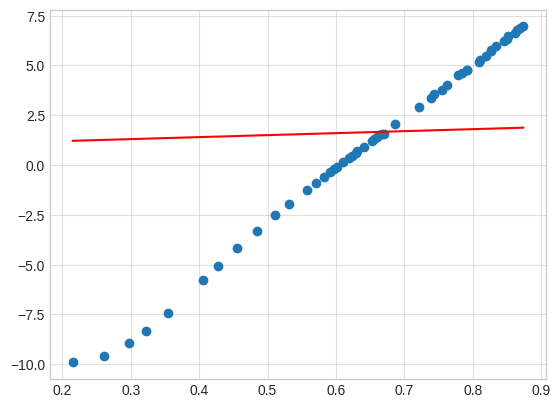

In [ ]:
plt.scatter(D1_V,D1_I)
x = np.linspace(np.min(D1_V),np.max(D1_V),1000)
y = [linear(i,m.values['a'],m.values['b']) for i in x]
plt.plot(x,y, color='r')

In [ ]:
c = LeastSquares()

TypeError: LeastSquares.__init__() missing 4 required positional arguments: 'x', 'y', 'yerror', and 'model'